In [1]:
import sys
import pandas as pd
import numpy as np
import requests
import json
from decimal import Decimal
import matplotlib.pyplot as plt
from uniswap import get_input_price, get_output_price, buy_to_price
from graph_util import fetch_safes, fetch_rp

## Pessimistic Assumptions
### 1) All RAI for collateral auctions will come from pools. No RAI-holding keepers bid on auctions
### 2) No arbing back to redemption price in pools when keepers purchase RAI
### 3) RAI maintains market_price = redemption_price on eth shock
### 4) Saviours not considered

## Optimistic Assumptions
### 1) Pool liquidity will not be reduced during ETH shock
### 2) Gas price not considered

In [2]:
#graphql_url = 'https://subgraph.reflexer.finance/subgraphs/name/reflexer-labs/rai'
graphql_url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'

In [3]:
eth_usd_url = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd'
ETH_USD = requests.get(eth_usd_url).json()['ethereum']['usd']

In [4]:
REDEMPTION_PRICE = fetch_rp(graphql_url)

In [5]:
orig_safes = fetch_safes(graphql_url)
#orig_safes = pd.read_csv('safes.csv')

In [6]:
orig_safes = orig_safes.query('debt > 0')

In [7]:
# Mainnet parameters
MAINNET_LIQ_RATIO = 1.40 


liq_penalty = 1.10
current_surplus = 493000
min_discount = 0.92
max_discount = 0.90
# use max_discount for collateral_auctions
DISCOUNT = max_discount

# RAI pools
rai_eth_v2 = 7.1E6
rai_eth_v3 = 58E3 
rai_dai_v3 = 4E6 
rai_usdc_v3 = 1E6 

rai_v2_pool = rai_eth_v2 + rai_eth_v3
usd_v2_pool = rai_v2_pool * REDEMPTION_PRICE
rai_v3_pool = rai_dai_v3 + rai_usdc_v3
usd_v3_pool = rai_v3_pool * REDEMPTION_PRICE


surplus_buffer = 500000 # Not currently used
discount_update_rate = Decimal(0.999991859697312485818842992) # Not currently used
liquidation_quantity = 90000.00 # Not currently used
on_auction_system_coin_limit = 4025086.73 # Not currently used

In [8]:
def update_cratios(safes, eth_price, redemption_price):
    # update c-ratio based on `eth_price` and `redemption_price`
    new_safes = safes.copy()
    new_safes['cratio'] = new_safes['collateral'] * eth_price / (new_safes['debt'] * redemption_price)
    return new_safes

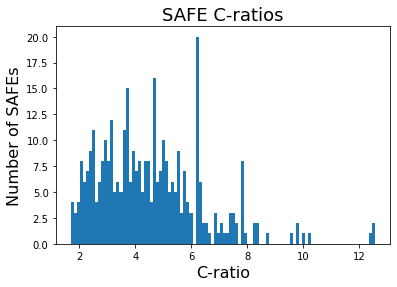

In [9]:
orig_safes = update_cratios(orig_safes, ETH_USD, REDEMPTION_PRICE)
orig_safes['cratio'].hist(bins=100)
plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.grid(False)
plt.show()

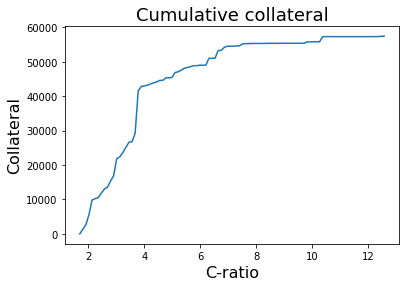

In [10]:
def plot_coll_cratios(safes):
    min_cratio = min(safes['cratio'])
    max_cratio = max(safes['cratio'])

    bins = 100
    #step = (max_cratio -  min_cratio) / bins
    cratios = [] 
    coll = []
    for cratio in np.linspace(min_cratio, max_cratio, bins):
        cratios.append(cratio)
        coll.append(safes.query(f'cratio < {cratio}')['collateral'].sum())


    plt.plot(cratios, coll)
    plt.title('Cumulative collateral', fontsize=18)
    plt.xlabel('C-ratio', fontsize=16)
    plt.ylabel('Collateral', fontsize=16)
    plt.show()
    
plot_coll_cratios(orig_safes)  

In [11]:
def liquidate_critical(safes, liq_cratio=1.40):
    # Return amount of collateral/debt liquidated
    critical_safes = safes.query(f'cratio < {liq_cratio}')

    critical_collateral = critical_safes['collateral'].sum()
    critical_debt = critical_safes['debt'].sum()

    return critical_collateral, critical_debt

def adjust_safe_debt_and_cratios(safes, debt_adj, eth_price, redemption_price):
    # adjust debt by `debt_adj` multiplier
    if debt_adj == 1:
        return safes
    new_safes = safes.copy()
    
    new_safes['debt'] *= debt_adj

    return update_cratios(new_safes, eth_price, redemption_price)

In [12]:
def run(orig_safes, liq_ratio, shock, current_surplus):
    
    # `debt_adj` is used to adjust individual SAFE debt to match expected values when liq_ratio is changed
    # This preserves safe debt as a multiplier of liq_ratio
    debt_adj =  MAINNET_LIQ_RATIO/ liq_ratio
    safes = adjust_safe_debt_and_cratios(orig_safes, debt_adj, ETH_USD, REDEMPTION_PRICE)
    
    # Set eth shock price
    eth_shock_price = ETH_USD * (1 - shock)
    
    # update c-ratios
    safes = update_cratios(safes, eth_shock_price, REDEMPTION_PRICE)

    # Liquidate all critical SAFEs
    critical_collateral, critical_debt = liquidate_critical(safes, liq_ratio)

    amount_to_raise = critical_debt * liq_penalty
    discount_collateral_price = eth_shock_price * DISCOUNT
    
    total_collateral_cost = critical_collateral * discount_collateral_price
    
    # Use v3 pool 
    # Assume rai market is redemption price and estamate slippage
    rai_v3_market_price = REDEMPTION_PRICE * 1.005 # Estimate slippage in V3 pool.

    # used up to the entire pool to buy discounted collateral
    v3_collateral_bought = min((rai_v3_pool * REDEMPTION_PRICE)/discount_collateral_price, critical_collateral) 

    collateral_left = critical_collateral - v3_collateral_bought

    rai_v3_spent = v3_collateral_bought * discount_collateral_price / REDEMPTION_PRICE

    amount_raised_v3 = rai_v3_spent

    if collateral_left == 0:
        amount_deficit = critical_debt - amount_raised_v3
    
    else: # Then use V2 pool

        amount_left_to_raise = amount_to_raise - rai_v3_spent

        collateral_left_cost = collateral_left * discount_collateral_price

        # max price to pay for RAI to make a profit on discounted collateral
        max_market_price = REDEMPTION_PRICE / DISCOUNT

        # Max amount to buy to put cost-basis at `max_market_price`
        how_much_v2_can_buy = 2 * buy_to_price(None, rai_v2_pool, goal_price=max_market_price, market_price=REDEMPTION_PRICE)

        # how is the pool affected when I make this buy
        # This just confirms the expected final market price
        #delta_usd, delta_rai = get_output_price(how_much_v2_can_buy, usd_v2_pool, rai_v2_pool, trade_fee=0.003)
        # new market price
        #print(f"market price after buy {(usd_v2_pool + delta_usd)/(rai_v2_pool + delta_rai):.2f}")

        amount_raised_v2 = min(amount_left_to_raise, how_much_v2_can_buy)

        amount_deficit = critical_debt - amount_raised_v2 - amount_raised_v3

    return current_surplus - amount_deficit

In [13]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

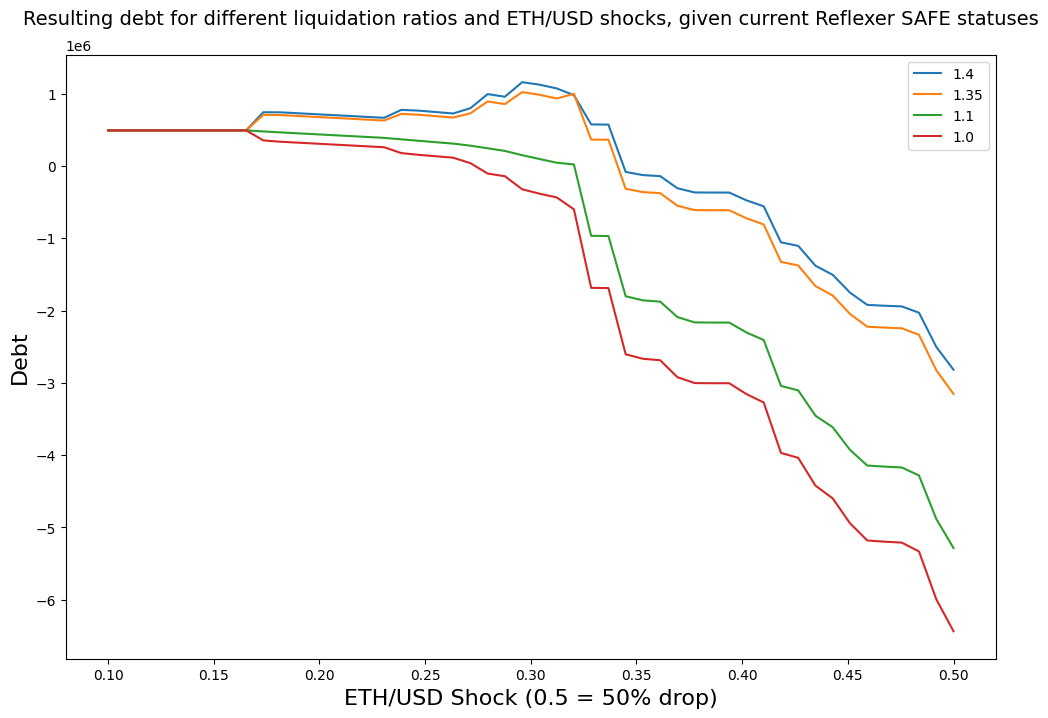

In [16]:
liq_ratios = [1.40, 1.35, 1.10, 1.0]
shocks = np.linspace(0.1, 0.5, 50)

for lr in liq_ratios:
    
    l = []
    s = []
    p = []
    for shock in shocks:
        surplus = run(orig_safes, lr, shock, current_surplus)
        l.append(lr)
        s.append(shock)
        p.append(surplus)
       # print(f"{lr=}, {shock=}, {surplus=}")

    plt.plot(s, p, label=lr)
    
plt.legend()
plt.title('Resulting debt for different liquidation ratios and ETH/USD shocks, given current Reflexer SAFE statuses\n', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Debt', fontsize=16)
plt.show()